In [27]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


sys.path.append('../../')
from util.preprocessing_utils import standardize_column
from util.dataframe_utils import analyse_columns
from util.datetime_utils import get_fractional_hour, fractional_hour_to_hms


In [28]:
df = pd.read_csv('../../data/processed/ProcessedTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negative_reason,negative_reason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,fractional_hour,hour_sin,hour_cos
0,570306133677760513,0,1.0000,0,0.0000,0,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,Unknown,Eastern Time (US & Canada),11.597778,0.105107,-0.994461
1,570301130888122368,1,0.3486,0,0.0000,0,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,Unknown,Pacific Time (US & Canada),11.266389,0.190880,-0.981613
2,570301083672813571,0,0.6837,0,0.0000,0,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),11.263333,0.191666,-0.981460
3,570301031407624196,2,1.0000,1,0.7033,0,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,Unknown,Pacific Time (US & Canada),11.260000,0.192522,-0.981293
4,570300817074462722,2,1.0000,2,1.0000,0,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,Unknown,Pacific Time (US & Canada),11.245833,0.196160,-0.980572


In [29]:
X_train, X_test, y_train, y_test = train_test_split(df[['airline_sentiment_confidence', 'airline', 'hour_sin', 'hour_cos']], 
                                                    df['airline_sentiment'], test_size=0.2, random_state=42)

In [30]:
with pm.Model() as model:
    data_vars = ['airline_sentiment_confidence', 'airline', 'hour_sin', 'hour_cos']
    shared_vars = {}
    for var in data_vars:
        shared_vars[var] = pm.Data(f'{var}_shared', X_train[var], mutable=True)

    class_prior = pm.Dirichlet('class_prior', a=np.ones(len(np.unique(y_train))))

    means = {}
    sigmas = {}
    for var in data_vars:
        means[var] = pm.Normal(f'means_{var}', mu=0, sigma=10, shape=len(np.unique(y_train)))
        sigmas[var] = pm.HalfNormal(f'sds_{var}', sigma=10, shape=len(np.unique(y_train)))

    y_likelihood = pm.Categorical('y_likelihood', p=class_prior, observed=y_train)

    for var in data_vars:
        pm.Normal(f'likelihood_{var}',
                  mu=means[var][y_train],
                  sigma=sigmas[var][y_train],
                  observed=shared_vars[var])

    nuts_sampler_kwargs = {'target_accept': 0.99, 'max_treedepth': 20}
    trace = pm.sample(2928, tune=1000, nuts_sampler_kwargs=nuts_sampler_kwargs, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [class_prior, means_airline_sentiment_confidence, sds_airline_sentiment_confidence, means_airline, sds_airline, means_hour_sin, sds_hour_sin, means_hour_cos, sds_hour_cos]


Sampling 4 chains for 1_000 tune and 2_928 draw iterations (4_000 + 11_712 draws total) took 119 seconds.


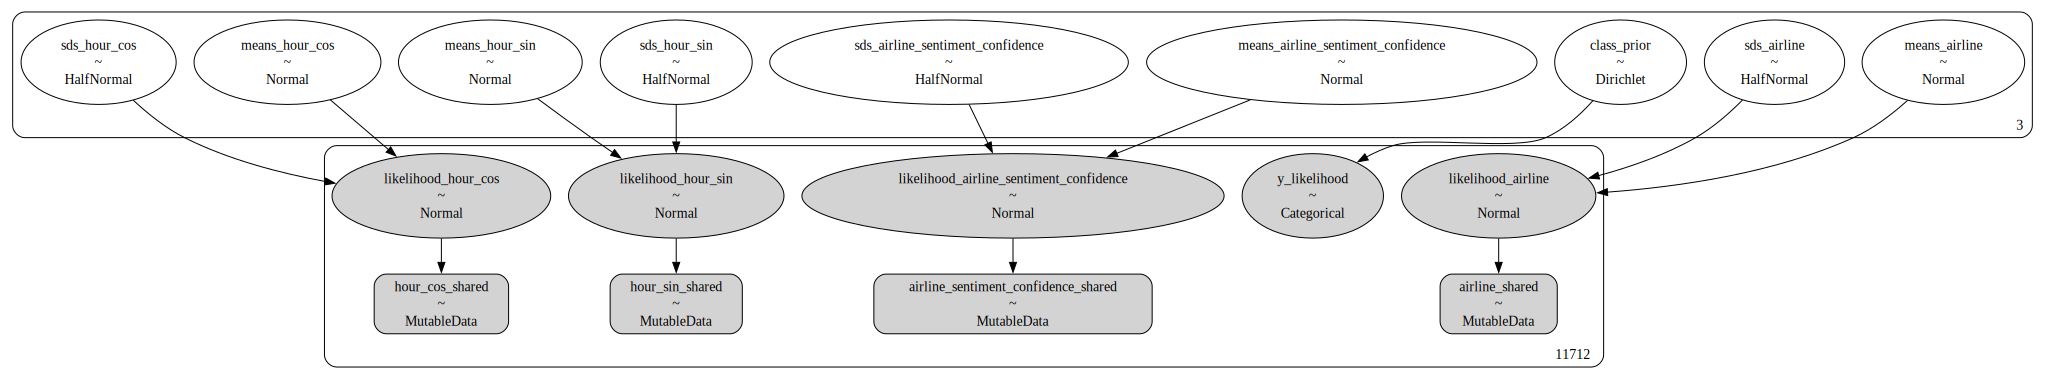

In [31]:
pm.model_to_graphviz(model)

In [32]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means_airline_sentiment_confidence[0],0.821,0.004,0.814,0.828,0.0,0.0,30472.0,9234.0,1.0
means_airline_sentiment_confidence[1],0.872,0.004,0.865,0.880,0.0,0.0,34025.0,8935.0,1.0
means_airline_sentiment_confidence[2],0.934,0.002,0.931,0.937,0.0,0.0,27341.0,8562.0,1.0
means_airline[0],2.601,0.030,2.546,2.657,0.0,0.0,29005.0,8390.0,1.0
means_airline[1],2.528,0.034,2.466,2.591,0.0,0.0,31426.0,8364.0,1.0
means_airline[2],2.929,0.019,2.892,2.963,0.0,0.0,27974.0,8228.0,1.0
means_hour_sin[0],-0.036,0.014,-0.062,-0.010,0.0,0.0,28870.0,8205.0,1.0
means_hour_sin[1],-0.060,0.016,-0.091,-0.030,0.0,0.0,29540.0,8555.0,1.0
means_hour_sin[2],-0.077,0.009,-0.094,-0.061,0.0,0.0,31605.0,8501.0,1.0
means_hour_cos[0],-0.383,0.012,-0.406,-0.361,0.0,0.0,25546.0,8435.0,1.0


## Airine Mappings

- Categorical encoding:

    0: 'neutral',

    1: 'positive',

    2: 'negative'

- Colour encoding:

    neutral: blue,

    negative: green,
    
    positive: orange


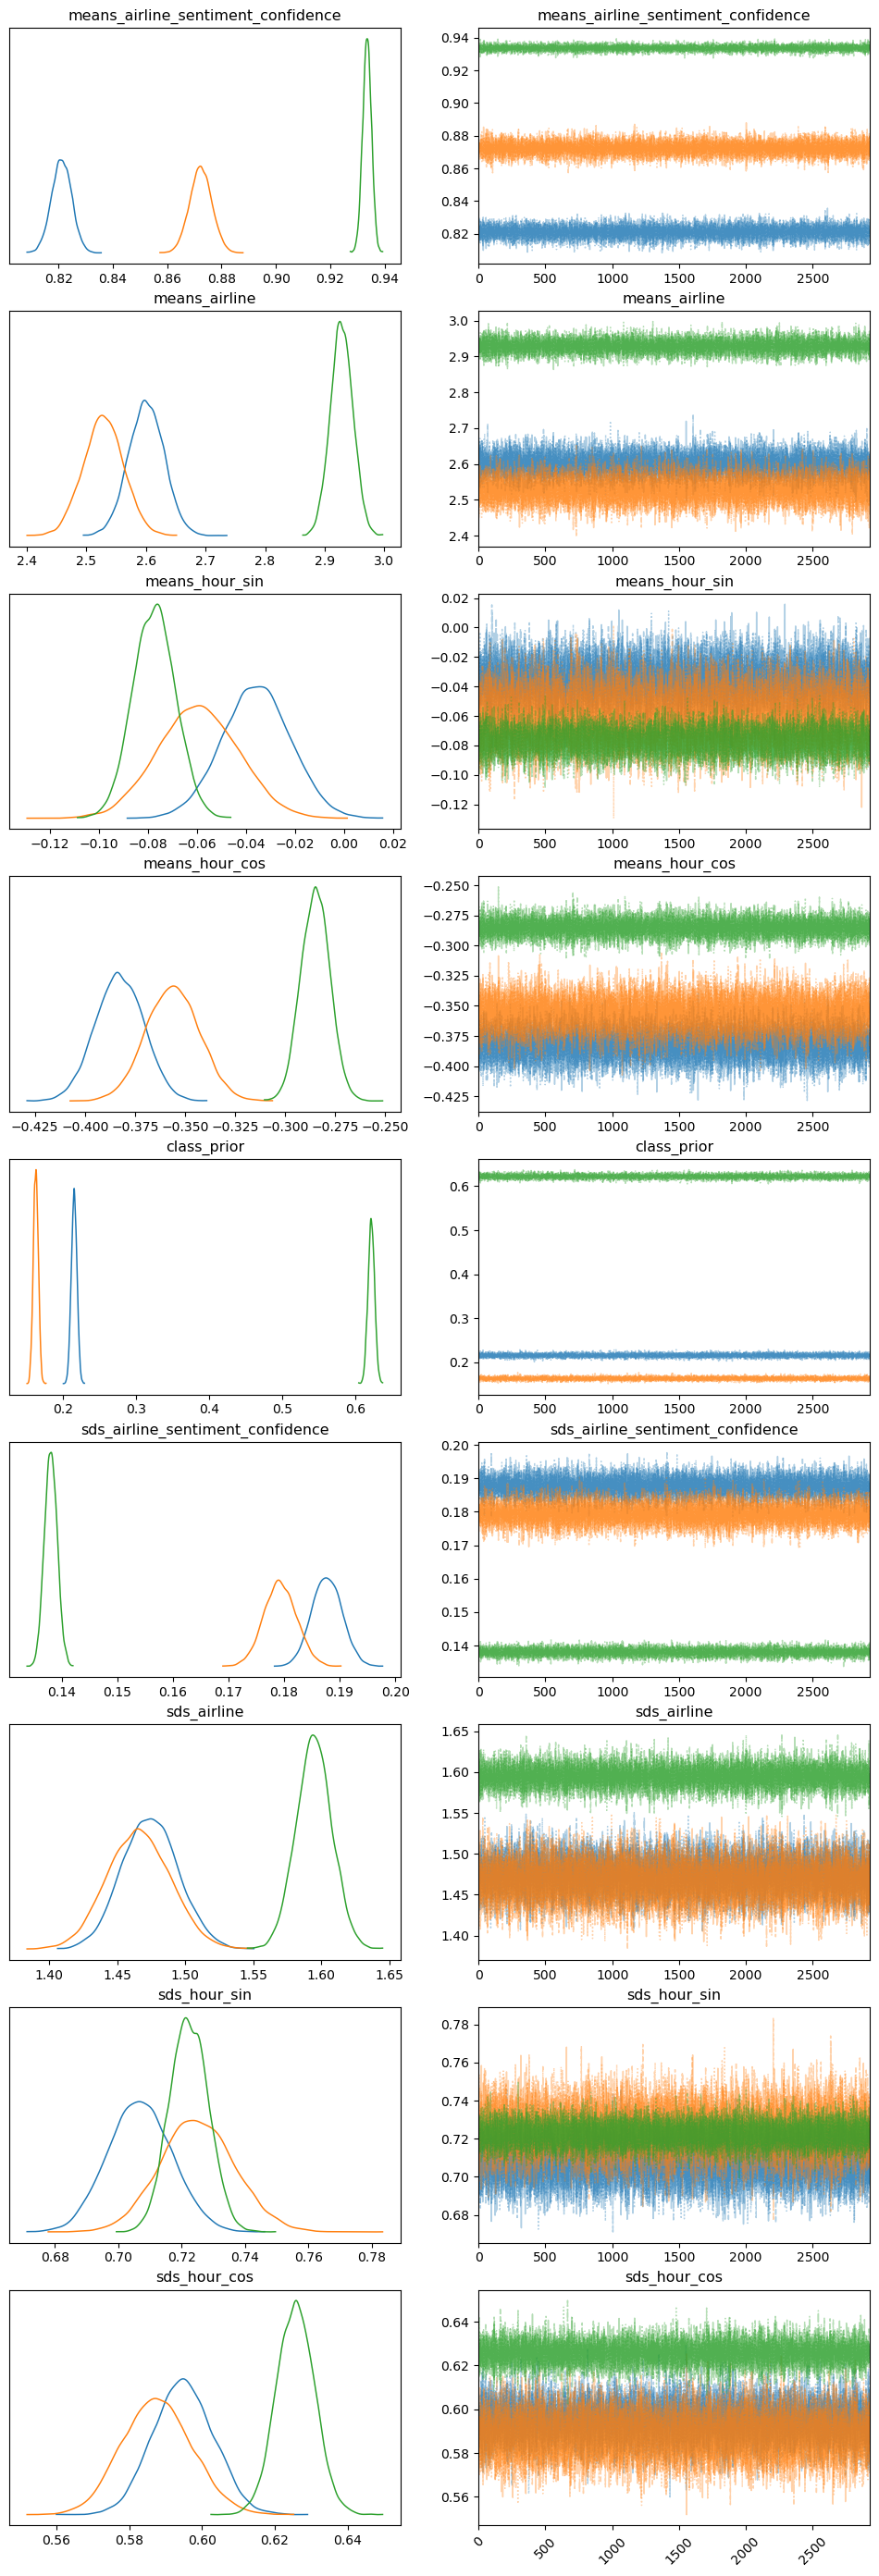

In [33]:
plt.rcParams['font.size'] = 10
az.plot_trace(trace, combined=True)
plt.xticks(rotation=45)
plt.subplots_adjust(top=2.5)
plt.subplots_adjust(bottom=1)

The visualizations segregate three sentiment classes in distinct hues, showcasing the model's grasp on categorical sentiment analysis. Key parameters—mean sentiment confidence, airline sentiment, and temporal patterns (via sine and cosine)—along with their standard deviations, capture both central tendencies and variabilities. The class_prior reflects initial sentiment class biases.

Theoretically now, I should be able to calculate the time of day that certain sentiments are most likely to be tweeted based on the sin and cosine hourly values. Let's attempt it:

In [34]:
sentiment_mapping = {0: 'neutral', 1: 'positive', 2: 'negative'}
sentiment_data = {
    0: {'means_hour_sin': -0.036, 'means_hour_cos': -0.383},
    1: {'means_hour_sin': -0.060, 'means_hour_cos': -0.356},
    2: {'means_hour_sin': -0.078, 'means_hour_cos': -0.285}
}

data_list = []

for key, data in sentiment_data.items():
    frac_hour = get_fractional_hour(data['means_hour_sin'], data['means_hour_cos'])
    hms = fractional_hour_to_hms(frac_hour)
    
    data_list.append({
        'Sentiment': sentiment_mapping[key],
        'Mean_Hour_Sin': data['means_hour_sin'],
        'Mean_Hour_Cos': data['means_hour_cos'],
        'Fractional_Hour': frac_hour,
        'Hour_HMS': hms
    })

sentiment_hours_df = pd.DataFrame(data_list)
sentiment_hours_df

,Sentiment,Mean_Hour_Sin,Mean_Hour_Cos,Fractional_Hour,Hour_HMS
0,neutral,-0.036,-0.383,12.357982,"(12, 21, 28)"
1,positive,-0.060,-0.356,12.637779,"(12, 38, 16)"
2,negative,-0.078,-0.285,13.020409,"(13, 1, 13)"


Now we have what appears to be the most likely hour per day to receive a tweet of a specific sentiment, and they are all clustered around midday. 

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

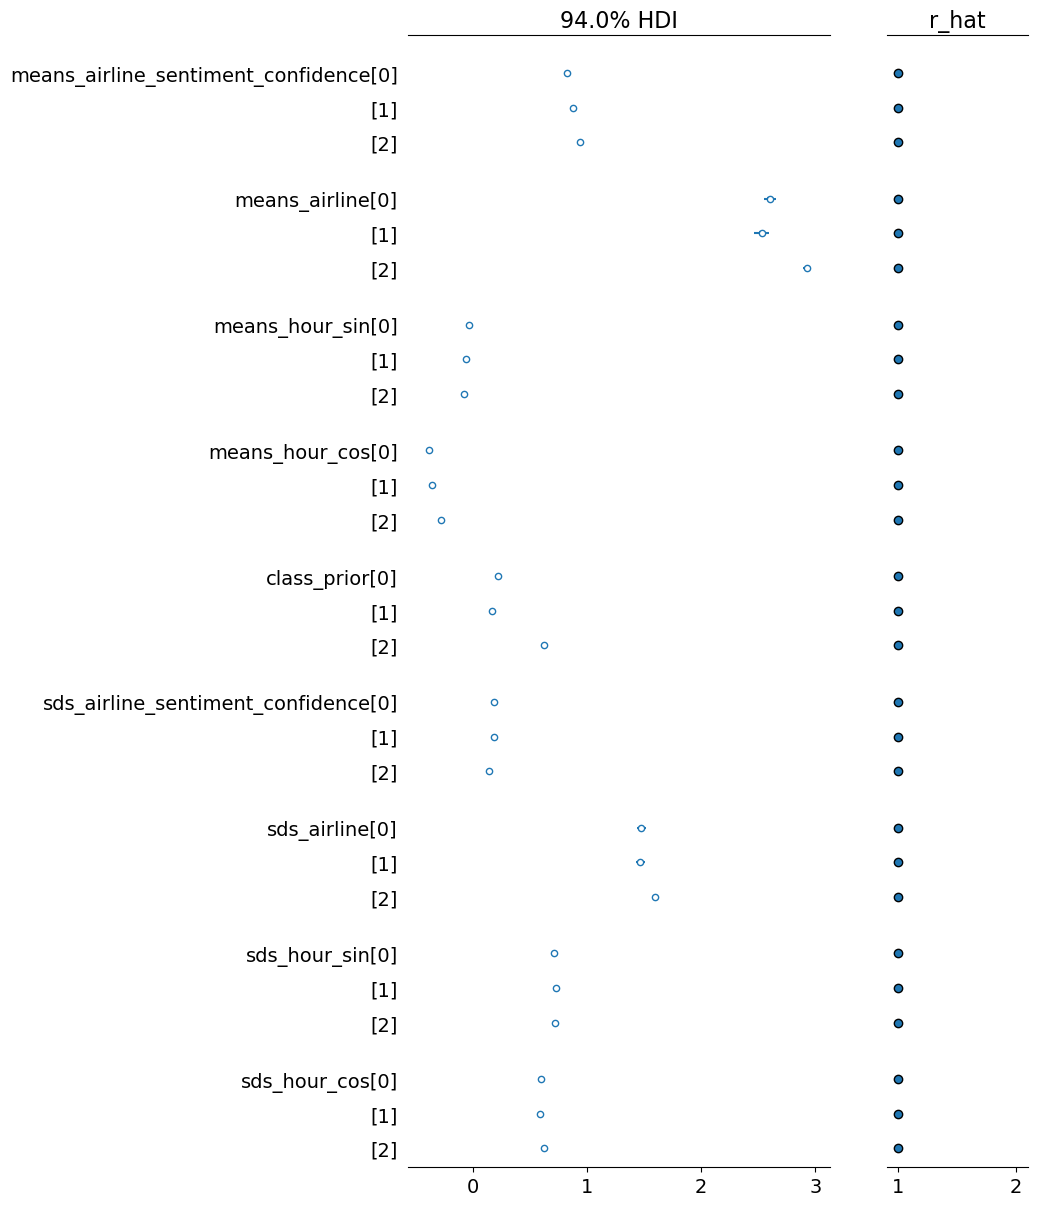

In [35]:
az.plot_forest(trace, combined=True, r_hat=True)

## Posterior Predictive Analysis

TO-DO: This is not currently working because the shapes are misaligned between X_test and y_train, but I'm putting it aside for now.

In [36]:
# with model:
#     data_vars = ['airline_sentiment_confidence', 'airline', 'hour_sin', 'hour_cos']
#     for var in data_vars:
#         pm.set_data({f'{var}_shared': X_test[var]})
#     post_pred = pm.sample_posterior_predictive(trace)